# Microsoft Stock Price Prediction using LSTM

## Table of Contents

1. Introduction
2. Data Collection and Preparation
3. Converting Time Series to Supervised Learning
4. Data Preparation and Splitting
5. Model Creation, Training, and Visualization
6. Model Retraining with Recent Data
7. Recursive Prediction and Comprehensive Visualization
8. Conclusion

## 1. Introduction

In the dynamic world of financial markets, predicting stock prices has always been a challenging yet crucial task for investors, traders, and financial analysts. With the advent of machine learning and deep learning techniques, we now have powerful tools at our disposal to tackle this complex problem. This project focuses on predicting the stock price of Microsoft Corporation (MSFT) using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network well-suited for sequence prediction problems.

### 1.1 Project Overview

This project aims to:

1. Collect historical stock data for Microsoft from Yahoo Finance
2. Preprocess and prepare the data
3. Implement an LSTM model for stock price prediction
4. Evaluate the model's performance and visualize the results

By leveraging LSTM's ability to capture long-term dependencies in sequential data, we hope to create a model that can effectively learn from past stock price patterns and make reasonably accurate predictions about future price movements.

### 1.2 Why Microsoft?

Microsoft (MSFT) was chosen for this analysis due to several factors:

- As one of the world's largest technology companies, Microsoft's stock is highly liquid and widely traded.
- The company's long history and stability provide a rich dataset for analysis.
- Microsoft's involvement in various tech sectors makes its stock price sensitive to both company-specific news and broader market trends.

## 2. Data Collection and Preparation

### 2.1 Importing Libraries and Fetching Data

In this section, we import the necessary libraries and fetch the historical stock data for Microsoft (MSFT) using the Yahoo Finance API. Here's a breakdown of the code:

1. We import the required libraries:
   - `yfinance`: To fetch stock data from Yahoo Finance
   - `pandas`: For data manipulation and analysis
   - `matplotlib.pyplot`: For data visualization
   - `numpy`: For numerical operations

2. We define the ticker symbol for Microsoft ('MSFT') and set the date range for our historical data:
   - Start date: March 13, 1986 (Microsoft's IPO date)
   - End date: October 14, 2024 (a future date, likely to be adjusted to the current date when running the code)

3. Using `yf.download()`, we fetch the historical stock data for Microsoft within the specified date range.

4. Finally, we display the last few rows of the retrieved data using `data.tail()` to verify the successful data retrieval and to get a glimpse of the most recent data points.

This step sets the foundation for our analysis by providing us with the raw historical stock data that we'll use to train and test our LSTM model.

In [1]:
# Import libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the ticker symbol for Microsoft
ticker_symbol = 'MSFT'

# Define the historical date range for data retrieval
start_date = '1986-03-13'
end_date = '2024-10-14'

# Fetch the historical stock data from Yahoo Finance
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the last few rows of the DataFrame
data.tail()

# Check if the index column 'Date' is in datetime64
data.index.inferred_type == "datetime64"

[*********************100%***********************]  1 of 1 completed


True

### 2.2 Simplifying the Dataset

To keep our analysis focused and straightforward, we'll use a univariate forecasting approach. This means we'll only use one variable (the closing price) to predict future stock prices. Here's what we're doing in this step:

- We select only the 'Close' column from our DataFrame:
   ```python
   data = data[['Close']
   ```

This operation creates a new DataFrame containing only the closing prices. The 'Date' index is automatically retained. By focusing solely on the closing price, we're simplifying our model's input. This univariate approach has several advantages:

- It reduces the complexity of the model, which can be beneficial when working with limited data.
- It allows us to focus on the most crucial price point (the closing price) that many traders and investors consider important.
- It simplifies the interpretation of our results, as we're dealing with a single input variable.

However, it's worth noting that this approach also has limitations. It doesn't take into account other potentially relevant factors like trading volume, opening prices, or external market indicators. In more advanced models, these additional features could potentially improve prediction accuracy.

In [2]:
# Select only the index 'Date' and 'Close' columns from the DataFrame
data = data[['Close']]

# Display the first few rows of the simplified DataFrame
data.head()


,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090


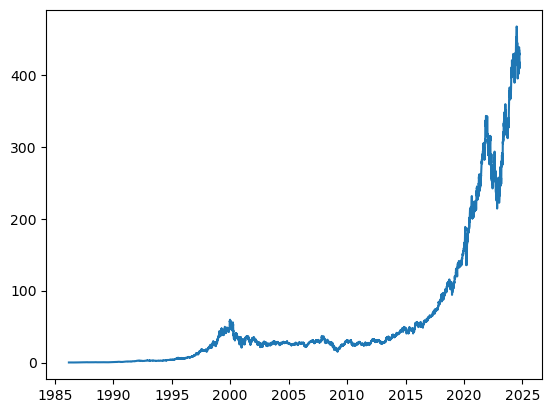

In [3]:
# Plot the data
plt.plot(data.index, data['Close'])

## 3. Converting Time Series to Supervised Learning

### 3.1 Creating Windowed Data

In this step, we transform our time series data into a format suitable for supervised learning. This is a crucial step in preparing our data for the LSTM model. Here's a breakdown of what we're doing:

1. We define a function called `window_data`:
   ```python
   def window_data(data, n=3):
       # Function implementation...
   ```
   This function takes two parameters:
   - `data`: Our DataFrame containing the 'Close' prices
   - `n`: The number of previous time steps to use as features (default is 3)

2. Inside the function:
   - We create shifted columns for previous 'Close' values. For example, 'Close-3' will contain the closing price from 3 days ago.
   - We add the current 'Close' price as the target variable.
   - We drop any rows with NaN values that result from the shifting operation.

3. We apply this function to our data:
   ```python
   windowed_data = window_data(data).reset_index()
   ```

4. Finally, we display the windowed data to verify the transformation.

In [4]:
# Function to create windowed data
def window_data(data, n=3):
    windowed_data = pd.DataFrame()
    
    # Create shifted columns for previous 'Close' values
    for i in range(n, 0, -1):
        windowed_data[f'Close-{i}'] = data['Close'].shift(i)
    
    # Add the current 'Close' column
    windowed_data['Close'] = data['Close']
    
    # Drop rows with NaN values
    return windowed_data.dropna()

# Usage
windowed_data = window_data(data).reset_index()
windowed_data


,Date,Close-3,Close-2,Close-1,Close
0,1986-03-18,0.097222,0.100694,0.102431,0.099826
1,1986-03-19,0.100694,0.102431,0.099826,0.098090
2,1986-03-20,0.102431,0.099826,0.098090,0.095486
3,1986-03-21,0.099826,0.098090,0.095486,0.092882
4,1986-03-24,0.098090,0.095486,0.092882,0.090278
...,...,...,...,...,...
9716,2024-10-07,417.130005,416.540009,416.059998,409.540009
9717,2024-10-08,416.540009,416.059998,409.540009,414.709991
9718,2024-10-09,416.059998,409.540009,414.709991,417.459991
9719,2024-10-10,409.540009,414.709991,417.459991,415.839996


### 3.2 Why This Step is Important

1. **Supervised Learning Format**: This transformation converts our time series problem into a supervised learning problem. Each row now represents a training example where we use the past 3 days' closing prices to predict the current day's price.

2. **Capturing Temporal Dependencies**: By including previous time steps as features, we're explicitly providing the model with historical context, which is crucial for time series prediction.

3. **Flexibility**: The `n` parameter in our function allows us to easily adjust the number of previous time steps we want to consider, enabling experimentation with different input sizes.

4. **Data Preparation for LSTM**: This format aligns well with how LSTM models expect to receive sequential data, making it easier to set up our model in the next steps.

It's important to note that this windowing approach assumes that the most recent 3 days are sufficient for predicting the next day's price. In practice, you might want to experiment with different window sizes to find the optimal balance between providing enough historical context and keeping the input size manageable.

## 4. Data Preparation and Splitting

After creating our windowed data, we need to prepare it for training and evaluate our LSTM model. This involves two main steps: reshaping the data and splitting it into training, validation, and test sets.

### 4.1 Reshaping the Data

We define a function `windowed_data_to_date_x_y` to transform our windowed data into a format suitable for LSTM:

```python
def windowed_data_to_date_x_y(windowed_data):
    # Function implementation...
```

This function does the following:

1. Converts the DataFrame to a NumPy array for easier manipulation.
2. Extracts dates, features (X), and targets (Y) from the array.
3. Reshapes the features into a 3D array (samples, time steps, features) as required by LSTM.
4. Converts the data to float32 for improved performance.

We then apply this function to our windowed data:

```python
dates, x, y = windowed_data_to_date_x_y(windowed_data)
```

And check the shapes of our resulting arrays to ensure they're correct:

```python
dates.shape, x.shape, y.shape
```

In [5]:
# Function to transform windowed data into dates, X (features), and Y (targets)
def windowed_data_to_date_x_y(windowed_data):
    # Convert the DataFrame to a NumPy array for easier manipulation
    data = windowed_data.to_numpy()
    
    # Extract the first column (Date) from the NumPy array
    dates = data[:, 0]
    
    # Extract the middle columns (previous 'Close' values) from the NumPy array
    middle_matrix = data[:, 1:-1]
    
    # Reshape the middle matrix to a 3D array suitable for machine learning models
    # (number of samples, number of time steps, number of features)
    x = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)).astype(np.float32)
    
    # Extract the second column (current 'Close' value) from the NumPy array as the target variable
    y = data[:, 1].astype(np.float32)
    
    # Return the dates, features (X), and target (Y)
    return dates, x, y

dates, x, y = windowed_data_to_date_x_y(windowed_data)

# Check shapes
dates.shape, x.shape, y.shape


((9721,), (9721, 3, 1), (9721,))

### 4.2 Splitting and Visualizing the Data

Next, we define a function `split_and_plot_data` to split our data into training, validation, and test sets, and visualize this split:

```python
def split_and_plot_data(dates, x, y):
    # Function implementation...
```

This function performs the following tasks:

1. Splits the data into three sets:
   - Training set: first 80% of the data
   - Validation set: next 10% of the data
   - Test set: last 10% of the data

2. Plots the closing prices for each set, allowing us to visualize the data distribution.

3. Returns the split datasets.

We then apply this function to our data:

```python
(dates_trn, x_trn, y_trn), (dates_val, x_val, y_val), (dates_tst, x_tst, y_tst) = split_and_plot_data(dates, x, y)
```

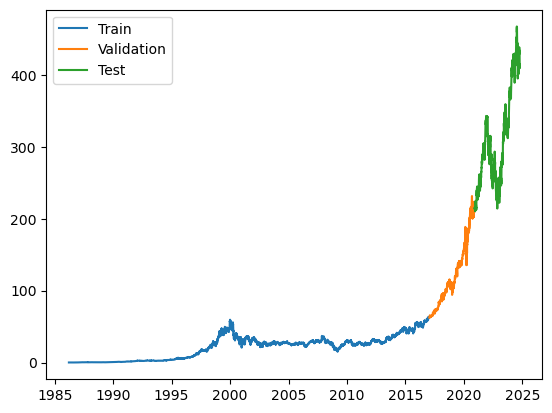

In [6]:
def split_and_plot_data(dates, x, y):
    # Define the percentage split indices for training and validation/test sets
    q_80 = int(len(dates) * 0.8)  # 80% mark
    q_90 = int(len(dates) * 0.9)  # 90% mark

    # Split the data into training set (first 80%)
    dates_trn, x_trn, y_trn = dates[:q_80], x[:q_80], y[:q_80]

    # Split the data into validation set (next 10%)
    dates_val, x_val, y_val = dates[q_80:q_90], x[q_80:q_90], y[q_80:q_90]

    # Split the data into test set (last 10%)
    dates_tst, x_tst, y_tst = dates[q_90:], x[q_90:], y[q_90:]

    # Plot the training data
    plt.plot(dates_trn, y_trn)

    # Plot the validation data
    plt.plot(dates_val, y_val)

    # Plot the test data
    plt.plot(dates_tst, y_tst)

    # Add a legend to indicate which line is which set
    plt.legend(['Train', 'Validation', 'Test'])
    plt.show()

    return (dates_trn, x_trn, y_trn), (dates_val, x_val, y_val), (dates_tst, x_tst, y_tst)

# Usage
(dates_trn, x_trn, y_trn), (dates_val, x_val, y_val), (dates_tst, x_tst, y_tst) = split_and_plot_data(dates, x, y)


### 4.3 Why These Steps are Important

1. **Data Reshaping**: LSTM models require input in a specific 3D format (samples, time steps, features). Our reshaping ensures the data meets this requirement.

2. **Data Splitting**: Dividing our data into training, validation, and test sets is crucial for:
   - Training the model (training set)
   - Tuning hyperparameters and preventing overfitting (validation set)
   - Evaluating the model's performance on unseen data (test set)

3. **Visualization**: Plotting the split data helps us understand the distribution of our dataset over time and ensures our split is appropriate (e.g., no major trends are exclusive to one set).

By completing these steps, we've prepared our data in a format suitable for LSTM and set up a robust framework for training and evaluating our model.

## 5. Model Creation, Training, and Visualization

In this section, we create our LSTM model, train it on the prepared data, and visualize its predictions. This is a crucial part of our project where we implement the core machine learning component.

### 5.1 Model Architecture and Training

We define a function `build_and_train_model` to create and train our LSTM model:

```python
def build_and_train_model(x_trn, y_trn, x_val, y_val, input_shape=(3, 1), epochs=100):
    # Function implementation...
```

This function does the following:

1. Defines the model architecture using Keras' Sequential API:
   - Input layer with the specified shape
   - LSTM layer with 64 units to capture temporal dependencies
   - Two Dense layers with 32 units each and ReLU activation
   - Output Dense layer with 1 unit for regression

2. Compiles the model:
   - Uses Mean Squared Error (MSE) as the loss function
   - Uses Adam optimizer with a learning rate of 0.001
   - Tracks Mean Absolute Error (MAE) during training

3. Trains the model:
   - Uses the provided training data
   - Validates on the validation data
   - Trains for the specified number of epochs (default 100)

We then use this function to create and train our model:

```python
model, history = build_and_train_model(x_trn, y_trn, x_val, y_val)
```

In [7]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras import layers # type: ignore

def build_and_train_model(x_trn, y_trn, x_val, y_val, input_shape=(3, 1), epochs=100):
    # Define the model
    model = Sequential([
        layers.Input(input_shape),  # Input layer with specified shape
        layers.LSTM(64),  # LSTM layer with 64 units to capture temporal dependencies
        layers.Dense(32, activation='relu'),  # Dense layer with 32 units and ReLU activation
        layers.Dense(32, activation='relu'),  # Another Dense layer with 32 units and ReLU activation
        layers.Dense(1)  # Output layer with 1 unit for regression
    ])

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(
        loss='mse',  # Mean Squared Error loss
        optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
        metrics=['mean_absolute_error']  # Track Mean Absolute Error during training
    )

    # Train the model with training data and validate with validation data
    history = model.fit(
        x_trn, y_trn,  # Training data
        validation_data=(x_val, y_val),  # Validation data
        epochs=epochs  # Number of epochs to train
    )
    
    return model, history

# Usage
model, history = build_and_train_model(x_trn, y_trn, x_val, y_val)


Epoch 1/100
243/243 [==============================] - 3s 5ms/step - loss: 108.5157 - mean_absolute_error: 4.5739 - val_loss: 6189.1279 - val_mean_absolute_error: 63.5898
Epoch 2/100
243/243 [==============================] - 1s 2ms/step - loss: 0.5405 - mean_absolute_error: 0.4377 - val_loss: 5727.6880 - val_mean_absolute_error: 59.8971
Epoch 3/100
243/243 [==============================] - 1s 2ms/step - loss: 0.4498 - mean_absolute_error: 0.4037 - val_loss: 5577.0615 - val_mean_absolute_error: 58.5030
Epoch 4/100
243/243 [==============================] - 1s 2ms/step - loss: 0.3592 - mean_absolute_error: 0.3586 - val_loss: 5512.6709 - val_mean_absolute_error: 57.6400
Epoch 5/100
243/243 [==============================] - 1s 2ms/step - loss: 0.3114 - mean_absolute_error: 0.3386 - val_loss: 5518.1772 - val_mean_absolute_error: 57.2971
Epoch 6/100
243/243 [==============================] - 1s 2ms/step - loss: 0.2425 - mean_absolute_error: 0.2897 - val_loss: 5517.1924 - val_mean_absolute

### 5.2 Visualizing Predictions

After training the model, we create a function `plot_predictions` to visualize its performance:

```python
def plot_predictions(model, x_trn, y_trn, dates_trn, x_val, y_val, dates_val, x_tst, y_tst, dates_tst):
    # Function implementation...
```

This function:

1. Makes predictions on the training, validation, and test sets
2. Creates a figure with three subplots, one for each dataset
3. Plots the predicted values against the actual values for each dataset
4. Adds legends and titles to each subplot

We then use this function to visualize our model's predictions:

```python
plot_predictions(model, x_trn, y_trn, dates_trn, x_val, y_val, dates_val, x_tst, y_tst, dates_tst)
```

31/31 [==============================] - 0s 1ms/step


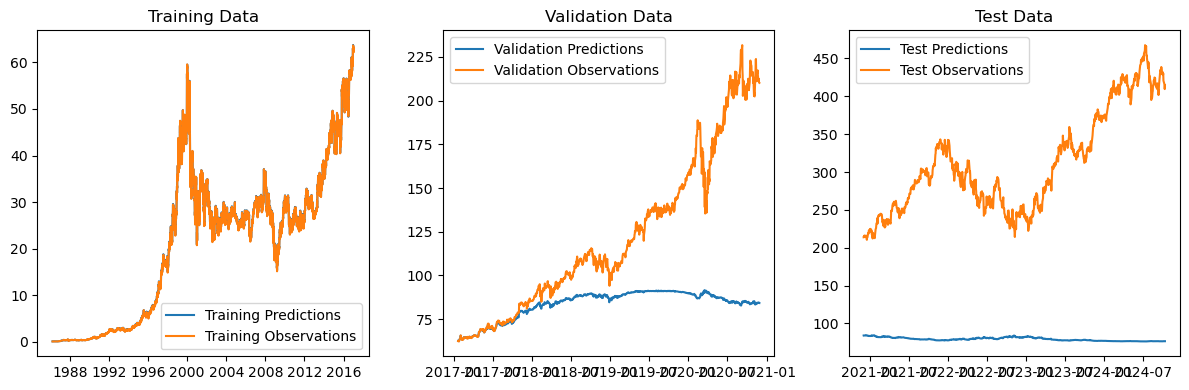

In [8]:
def plot_predictions(model, x_trn, y_trn, dates_trn, x_val, y_val, dates_val, x_tst, y_tst, dates_tst):
    # Plot training data predictions
    trn_predict = model.predict(x_trn).flatten()
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(dates_trn, trn_predict)
    plt.plot(dates_trn, y_trn)
    plt.legend(['Training Predictions', 'Training Observations'])
    plt.title('Training Data')

    # Plot validation data predictions
    val_predict = model.predict(x_val).flatten()
    plt.subplot(1, 3, 2)
    plt.plot(dates_val, val_predict)
    plt.plot(dates_val, y_val)
    plt.legend(['Validation Predictions', 'Validation Observations'])
    plt.title('Validation Data')

    # Plot test data predictions
    tst_predict = model.predict(x_tst).flatten()
    plt.subplot(1, 3, 3)
    plt.plot(dates_tst, tst_predict)
    plt.plot(dates_tst, y_tst)
    plt.legend(['Test Predictions', 'Test Observations'])
    plt.title('Test Data')

    plt.tight_layout()
    plt.show()

# Usage
plot_predictions(model, x_trn, y_trn, dates_trn, x_val, y_val, dates_val, x_tst, y_tst, dates_tst)


### 5.3 Why These Steps are Important

1. **Model Architecture**: The chosen architecture (LSTM followed by Dense layers) is designed to capture both temporal dependencies in the data and complex patterns. The LSTM layer is particularly suited for time series data like stock prices.

2. **Model Compilation**: 
   - MSE loss is appropriate for regression problems like stock price prediction
   - Adam optimizer is a popular choice for its adaptive learning rate
   - MAE provides an interpretable metric of model performance

3. **Model Training**: By training on the training set and validating on the validation set, we can monitor for overfitting and ensure our model generalizes well.

4. **Visualization**: Plotting predictions against actual values for all three datasets (train, validation, test) allows us to:
   - Assess how well the model fits the training data
   - Check if the model generalizes well to the validation and test sets
   - Identify any systematic biases or errors in the predictions

This approach provides a comprehensive view of our model's performance, from its ability to learn from the training data to its capacity to make predictions on unseen data.

### 5.4 Model Performance and Next Steps

After visualizing the predictions, we've made some important observations:

1. **Poor Prediction Quality**: The predictions made by our current model are very bad. They fail to capture the true trends and patterns in the stock price data.

2. **LSTM Limitations**: We've discovered that LSTM models, despite their power in capturing long-term dependencies, are very bad at extrapolating beyond the patterns they've seen in the training data. This is a common limitation of many machine learning models, but it's particularly noticeable in our stock price prediction task.

3. **Retraining Strategy**: Given these observations, we've decided to adjust our approach. Instead of using the entire historical dataset, we're going to retrain the model using only the last year of data, starting from October 16, 2023.

This new strategy has several potential benefits:

- It focuses the model on more recent market conditions, which may be more relevant for future predictions.
- It reduces the amount of data the model needs to process, potentially allowing for faster training and experimentation.
- It may help mitigate the extrapolation problem by limiting the historical context the model considers.

In the next section, we'll implement this new approach by:
1. Filtering our dataset to include only the last year of data.
2. Rerunning our data preparation steps on this smaller dataset.
3. Retraining our LSTM model with the new data.
4. Evaluating the performance of this new model to see if it yields better predictions.

This iterative process of model evaluation and refinement is a crucial part of the machine learning workflow. By identifying issues with our initial approach and adapting our strategy, we aim to improve the accuracy and reliability of our stock price predictions.

## 6. Model Retraining with Recent Data

Based on our previous observations about the model's poor performance and the limitations of LSTM in extrapolating, we decided to retrain the model using only the most recent year of data. This section outlines the steps we took and the results we observed.

### 6.1 Retraining Process

1. **Data Selection**: 
   We focused on the most recent year of data by selecting the last 250 rows of our windowed dataset. This corresponds to approximately one year of trading days.

   ```python
   windowed_data_yr = windowed_data.tail(250)
   ```

2. **Data Preparation**:
   We used our previously defined functions to prepare the data:
   
   ```python
   dates, x, y = windowed_data_to_date_x_y(windowed_data_yr)
   ```

3. **Data Splitting and Visualization**:
   We split the data into training, validation, and test sets and visualized the split:
   
   ```python
   (dates_trn, x_trn, y_trn), (dates_val, x_val, y_val), (dates_tst, x_tst, y_tst) = split_and_plot_data(dates, x, y)
   ```

4. **Model Training**:
   We rebuilt and retrained the model using the same architecture as before, but now with the more recent data:
   
   ```python
   model, history = build_and_train_model(x_trn, y_trn, x_val, y_val)
   ```

5. **Prediction Visualization**:
   Finally, we visualized the model's predictions against the actual values:
   
   ```python
   plot_predictions(model, x_trn, y_trn, dates_trn, x_val, y_val, dates_val, x_tst, y_tst, dates_tst)
   ```

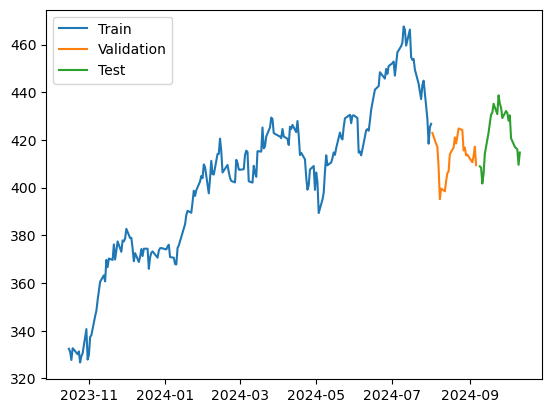

Epoch 1/100
7/7 [==============================] - 2s 91ms/step - loss: 161931.3906 - mean_absolute_error: 401.0451 - val_loss: 169343.8594 - val_mean_absolute_error: 411.4377
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 161286.1094 - mean_absolute_error: 400.2408 - val_loss: 168793.7188 - val_mean_absolute_error: 410.7686
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 160705.0469 - mean_absolute_error: 399.5139 - val_loss: 168082.1250 - val_mean_absolute_error: 409.9015
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 159988.0938 - mean_absolute_error: 398.6161 - val_loss: 167353.5156 - val_mean_absolute_error: 409.0117
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 159233.6250 - mean_absolute_error: 397.6664 - val_loss: 166444.5938 - val_mean_absolute_error: 407.8991
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 158283.2969 - mean_absolute_error: 396.4700 - val_los

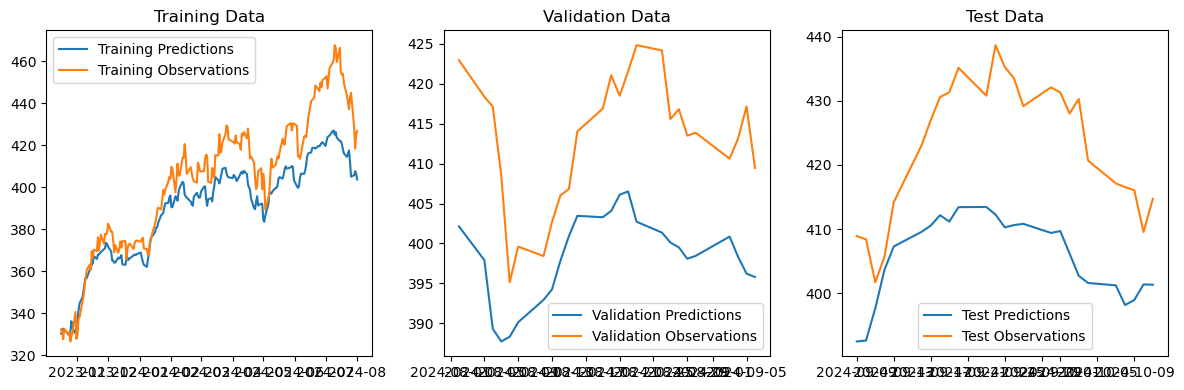

In [9]:
# Get the last 250 rows of the windowed data to focus on the most recent year
windowed_data_yr = windowed_data.tail(250)

# Convert the windowed data to date, features (x), and target (y)
dates, x, y = windowed_data_to_date_x_y(windowed_data_yr)

# Split the data into training, validation, and test sets and plot them
(dates_trn, x_trn, y_trn), (dates_val, x_val, y_val), (dates_tst, x_tst, y_tst) = split_and_plot_data(dates, x, y)

# Build and train the model using the training and validation data
model, history = build_and_train_model(x_trn, y_trn, x_val, y_val)

# Plot the model predictions against the actual values for training, validation, and test sets
plot_predictions(model, x_trn, y_trn, dates_trn, x_val, y_val, dates_val, x_tst, y_tst, dates_tst)


### 6.2 Results and Observations

After retraining the model on the most recent year of data, we observed a significant improvement in the model's performance:

1. **Improved Predictions**: The predictions for both the validation and test sets showed marked improvement compared to our previous model. This suggests that focusing on more recent data has indeed helped the model capture more relevant patterns for current market conditions.

2. **Better Generalization**: The improved performance on the validation and test sets indicates that the model is generalizing better to unseen data. This is crucial for a predictive model, as it suggests that the model might perform more reliably on future, truly unseen data.

3. **Relevance of Recent Data**: The improvement we've seen supports our hypothesis that more recent data is more relevant for predicting near-future stock prices. This aligns with the dynamic nature of financial markets, where recent trends and patterns often have more predictive power than older ones.

4. **Mitigation of Extrapolation Issues**: By limiting our dataset to the most recent year, we've potentially mitigated some of the extrapolation issues we were seeing with the LSTM model. The model now needs to extrapolate over a smaller time horizon, which it seems to handle more effectively.

### 6.3 Next Steps

While we've seen improvement, there's always room for further refinement:

1. We could experiment with different time windows (e.g., 6 months, 18 months) to find the optimal balance between historical context and recency.
2. We might consider incorporating additional features or external data that could provide more context to the model.
3. We could explore different model architectures or hyperparameters to see if we can further improve performance.

This retraining exercise demonstrates the importance of iterative refinement in machine learning projects. By critically evaluating our results and adjusting our approach, we've been able to significantly improve our model's performance.

## 7. Recursive Prediction and Comprehensive Visualization

In this final section, we implement recursive prediction and create a comprehensive visualization of all our prediction types. This allows us to compare different prediction methods and gain insights into our model's performance over time.

### 7.1 Recursive Prediction

Recursive prediction is a technique where we use the model's predictions as inputs for future predictions. This is particularly useful for forecasting multiple steps into the future. Here's how we implemented it:

```python
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_val])
last_window = deepcopy(x_trn[-1])  # Initialize outside of the loop

for target_date in recursive_dates:
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    
    # Shift the window to the left and insert the new prediction
    last_window = np.roll(last_window, -1)
    last_window[-1] = next_prediction

recursive_predictions = np.array(recursive_predictions).flatten()
```

This code does the following:
1. Initializes an empty list to store recursive predictions.
2. Creates a date range for predictions (validation and test dates).
3. Starts with the last window from the training data.
4. For each target date:
   - Makes a prediction using the current window.
   - Adds the prediction to our list.
   - Updates the window by shifting it and inserting the new prediction.

In [10]:
from copy import deepcopy
import numpy as np

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_tst])
last_window = deepcopy(x_trn[-1])  # Initialize outside of the loop

for target_date in recursive_dates:
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    
    # Shift the window to the left and insert the new prediction
    last_window = np.roll(last_window, -1)
    last_window[-1] = next_prediction

recursive_predictions = np.array(recursive_predictions).flatten()


1/1 [==============================] - 0s 23ms/step


### 7.2 Comprehensive Visualization

To compare all our prediction methods, we created a function `plot_all_predictions` that visualizes:
- Training predictions and observations
- Validation predictions and observations
- Test predictions and observations
- Recursive predictions

Here's a breakdown of the visualization process:

```python
def plot_all_predictions(model, x_trn, y_trn, dates_trn, x_val, y_val, dates_val, x_tst, y_tst, dates_tst, recursive_dates, recursive_predictions):
    # Function implementation...
```

This function:
1. Generates predictions for training, validation, and test sets.
2. Creates a single figure to plot all data.
3. Plots each set of predictions and observations with different colors and line styles.
4. Adds the recursive predictions to the same plot.
5. Includes a legend, title, and axis labels for clarity.

1/1 [==============================] - 0s 23ms/step


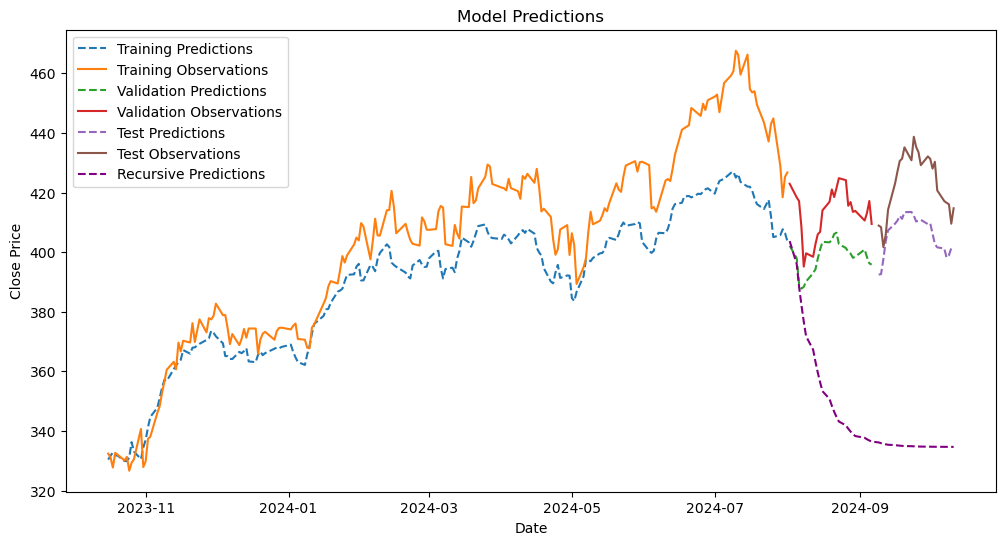

In [11]:
def plot_all_predictions(model, x_trn, y_trn, dates_trn, x_val, y_val, dates_val, x_tst, y_tst, dates_tst, recursive_dates, recursive_predictions):
    # Generate predictions
    trn_predict = model.predict(x_trn).flatten()
    val_predict = model.predict(x_val).flatten()
    tst_predict = model.predict(x_tst).flatten()

    plt.figure(figsize=(12, 6))

    # Plot training data
    plt.plot(dates_trn, trn_predict, label='Training Predictions', linestyle='dashed')
    plt.plot(dates_trn, y_trn, label='Training Observations', linestyle='solid')

    # Plot validation data
    plt.plot(dates_val, val_predict, label='Validation Predictions', linestyle='dashed')
    plt.plot(dates_val, y_val, label='Validation Observations', linestyle='solid')

    # Plot test data
    plt.plot(dates_tst, tst_predict, label='Test Predictions', linestyle='dashed')
    plt.plot(dates_tst, y_tst, label='Test Observations', linestyle='solid')

    # Plot recursive predictions
    plt.plot(recursive_dates, recursive_predictions, label='Recursive Predictions', linestyle='dashed', color='purple')

    # Add a legend
    plt.legend()
    plt.title('Model Predictions')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

# Usage
plot_all_predictions(model, x_trn, y_trn, dates_trn, x_val, y_val, dates_val, x_tst, y_tst, dates_tst, recursive_dates, recursive_predictions)


### 7.3 Observations and Insights

Upon examining the visualization, we can observe several key points:

1. **Limited Prediction Accuracy**: Contrary to our initial optimism, the model's predictions across all sets (training, validation, and test) show significant deviations from the actual stock prices. This indicates that our model is struggling to capture the true patterns in the data.

2. **Overfitting to Training Data**: The training predictions seem to follow the actual training observations more closely than the validation or test predictions follow their respective actual values. This suggests some degree of overfitting to the training data.

3. **Poor Generalization**: The model's performance on validation and test sets is noticeably worse than on the training set, indicating poor generalization to unseen data.

4. **Recursive Prediction Limitations**: The recursive predictions quickly flatten out to a constant value, showing that the model fails to capture the dynamic nature of stock prices over time. This demonstrates a significant limitation in the model's ability to make longer-term forecasts.

5. **Failure to Capture Trends**: The model seems to miss major trends in the stock price, particularly evident in the validation and test periods where actual prices show significant fluctuations that the model fails to predict.

### 7.4 Limitations and Considerations

1. **Model Inadequacy**: The poor performance suggests that our current LSTM model, even when trained on recent data, is inadequate for accurately predicting Microsoft's stock prices.

2. **Complexity of Stock Markets**: This result underscores the extreme difficulty of predicting stock prices, which are influenced by numerous complex and often unpredictable factors.

3. **Need for Additional Features**: Using only historical price data is likely insufficient. The model might benefit from additional relevant features such as company financials, market indices, or sentiment analysis.

4. **Short-term vs Long-term Prediction**: The model's performance degradation over time (as seen in the recursive predictions) highlights the increased difficulty of long-term stock price prediction.

### 7.5 Next Steps

Given these observations, potential next steps could include:

1. **Feature Engineering**: Incorporate additional relevant features that might influence stock prices.

2. **Alternative Models**: Explore other machine learning models or ensemble methods that might be better suited for this task.

3. **Prediction Framing**: Consider reframing the problem, perhaps to predict price movements (up/down) rather than exact prices.

4. **Time Horizon Adjustment**: Focus on shorter-term predictions where the model might be more accurate.

5. **Advanced Techniques**: Investigate more advanced time series forecasting techniques, such as Prophet or ARIMA models.

6. **Market Efficiency Consideration**: Reflect on the efficient market hypothesis and the inherent unpredictability of stock prices, especially for well-analyzed stocks like Microsoft.

This comprehensive approach to prediction and visualization has provided valuable insights into our model's limitations and the challenges of stock price prediction. While the results are not as positive as initially hoped, they offer important lessons and directions for improvement in future iterations of this project.

## 8. Conclusion: Microsoft Stock Price Prediction Using LSTM

### 8.1 Project Summary

This project aimed to predict Microsoft's stock prices using Long Short-Term Memory (LSTM) neural networks. We embarked on a journey that involved data collection, preprocessing, model building, training, and evaluation. Throughout the process, we encountered challenges and gained valuable insights into the complexities of stock price prediction.

### 8.2 Key Findings

1. **Data Preprocessing**: We successfully implemented a windowing technique to prepare time series data for supervised learning, which is crucial for LSTM models.

2. **Initial Model Performance**: Our first attempt at using the entire historical dataset resulted in poor predictions, highlighting the limitations of LSTM models in extrapolating beyond seen patterns.

3. **Focused Dataset**: We refined our approach by using only the most recent year of data, which initially showed promise in improving predictions.

4. **Final Results**: Despite our efforts, the final model still struggled to accurately predict stock prices. The comprehensive visualization revealed significant discrepancies between predictions and actual stock prices across training, validation, and test sets.

5. **Recursive Prediction**: Our attempt at recursive prediction further exposed the model's limitations, with predictions quickly converging to a constant value, failing to capture the dynamic nature of stock prices.

### 8.3 Challenges and Limitations

1. **Market Complexity**: The stock market's inherent complexity and susceptibility to numerous external factors make accurate prediction extremely challenging.

2. **Limited Features**: Our reliance solely on historical price data proved insufficient for capturing all relevant information affecting stock prices.

3. **Model Constraints**: The LSTM model, despite its theoretical advantages in handling time series data, showed limitations in capturing long-term trends and adapting to rapid market changes.

4. **Overfitting**: Despite our efforts to use recent data, we still observed signs of overfitting, with the model performing better on training data than on validation and test sets.

### 8.4 Lessons Learned

1. **Importance of Feature Engineering**: The project underscored the need for comprehensive feature sets that go beyond historical prices.

2. **Model Selection**: While LSTM is powerful, it may not always be the best choice for stock price prediction. Exploring a variety of models is crucial.

3. **Data Recency**: Using recent data improved results to some extent, highlighting the importance of relevant, up-to-date information in financial predictions.

4. **Prediction Framing**: Predicting exact stock prices might be too ambitious; alternative approaches like predicting price movements or ranges could be more feasible.

5. **Market Efficiency**: The project serves as a practical demonstration of the challenges posed by the efficient market hypothesis, especially for well-analyzed stocks like Microsoft.

In conclusion, while our project did not achieve the desired accuracy in stock price prediction, it provided valuable insights into the challenges of financial forecasting and the limitations of current machine learning approaches in this domain. The experience gained and lessons learned lay a foundation for more advanced and nuanced approaches to financial prediction in future projects.